<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_4_imdb_reviews_with_GRU_LSTM_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Building Models for the IMDB Reviews Dataset

In this lab, you will build four models and train it on the [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) with full word encoding. These use different layers after the embedding namely `Flatten`, `LSTM`, `GRU`, and `Conv1D`. You will compare the performance and see which architecture might be best for this particular dataset. Let's begin!

## Imports

You will first import common libraries that will be used throughout the exercise.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download and Prepare the Dataset

Next, you will download the `plain_text` version of the `IMDB Reviews` dataset.

In [2]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteI8RVM4/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteI8RVM4/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteI8RVM4/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

Unlike the subword encoded set you've been using in the previous labs, you will need to build the vocabulary from scratch and generate padded sequences. You already know how to do that with the `Tokenizer` class and `pad_sequences()` method.

In [4]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

## Plot Utility

Before you define the models, you will define the function below so you can easily visualize the accuracy and loss history after training.

In [5]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Model 1: Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

*Note: You might see a different graph in the lectures. This is because we adjusted the `BATCH_SIZE` for training so subsequent models will train faster.*

In [6]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171533 (670.05 KB)
Trainable params: 171533 (670.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 3s 11ms/step - loss: 0.6140 - accuracy: 0.6512 - val_loss: 0.3997 - val_accuracy: 0.8325
Epoch 2/10
196/196 [==============================] - 2s 12ms/step - loss: 0.3193 - accuracy: 0.8678 - val_loss: 0.3362 - val_accuracy: 0.8540
Epoch 3/10
196/196 [==============================] - 4s 21ms/step - loss: 0.2017 - accuracy: 0.9279 - val_loss: 0.3513 - val_accuracy: 0.8477
Epoch 4/10
196/196 [==============================] - 2s 12ms/step - loss: 0.1122 - accuracy: 0.9719 - val_loss: 0.3909 - val_accuracy: 0.8405
Epoch 5/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0520 - accuracy: 0.9931 - val_loss: 0.4368 - val_accuracy: 0.8368
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0245 - accuracy: 0.9984 - val_loss: 0.4769 - val_accuracy: 0.8354
Epoch 7/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0131 - accuracy: 0.9993 - val_loss: 0.5130 - val_accuracy: 0.8316

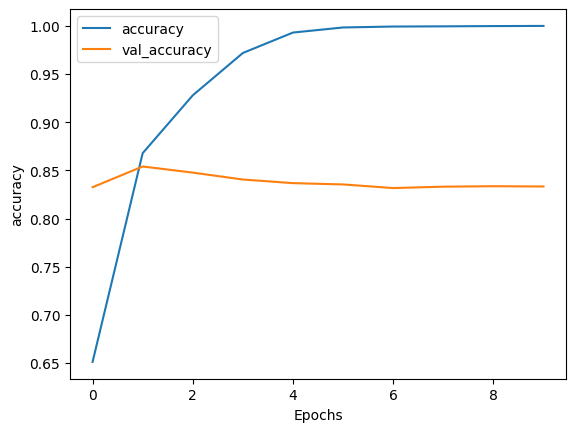

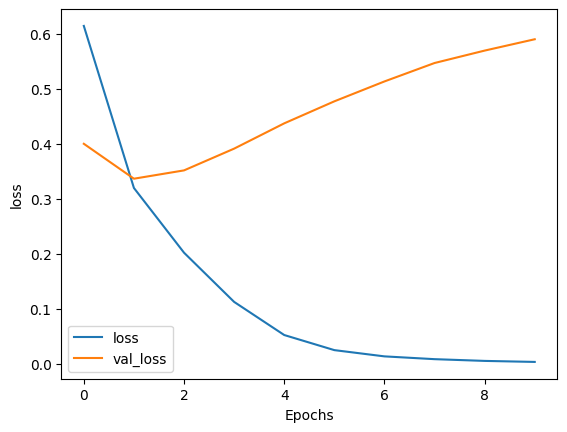

In [8]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

## LSTM

Next, you will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.

In [9]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 64)                12544     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172941 (675.55 KB)
Trainable params: 172941 (675.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 45s 199ms/step - loss: 0.5385 - accuracy: 0.7156 - val_loss: 0.4096 - val_accuracy: 0.8270
Epoch 2/10
196/196 [==============================] - 39s 201ms/step - loss: 0.3136 - accuracy: 0.8704 - val_loss: 0.3477 - val_accuracy: 0.8508
Epoch 3/10
196/196 [==============================] - 36s 184ms/step - loss: 0.2473 - accuracy: 0.9046 - val_loss: 0.3997 - val_accuracy: 0.8323
Epoch 4/10
196/196 [==============================] - 38s 196ms/step - loss: 0.2125 - accuracy: 0.9202 - val_loss: 0.3864 - val_accuracy: 0.8348
Epoch 5/10
196/196 [==============================] - 38s 196ms/step - loss: 0.1842 - accuracy: 0.9344 - val_loss: 0.4837 - val_accuracy: 0.8244
Epoch 6/10
196/196 [==============================] - 38s 195ms/step - loss: 0.1600 - accuracy: 0.9443 - val_loss: 0.4725 - val_accuracy: 0.8236
Epoch 7/10
196/196 [==============================] - 38s 194ms/step - loss: 0.1281 - accuracy: 0.9591 - val_loss: 0.5765 - val_ac

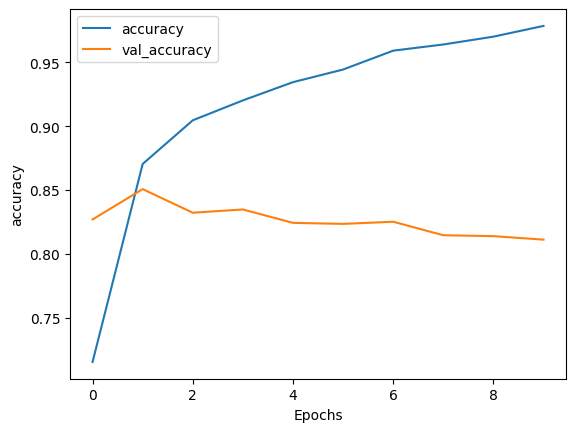

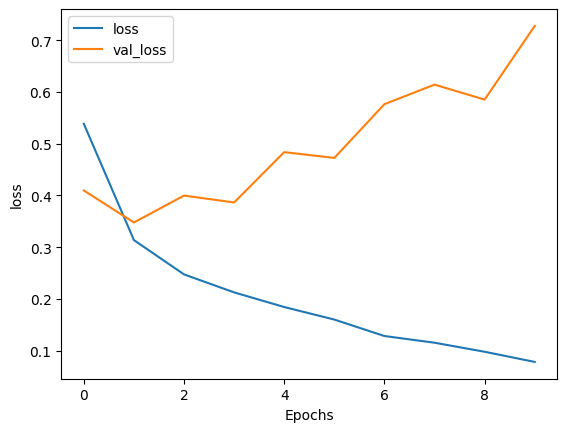

In [11]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

## GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [12]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169997 (664.05 KB)
Trainable params: 169997 (664.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 42s 192ms/step - loss: 0.5748 - accuracy: 0.6695 - val_loss: 0.3628 - val_accuracy: 0.8440
Epoch 2/10
196/196 [==============================] - 39s 198ms/step - loss: 0.3105 - accuracy: 0.8686 - val_loss: 0.3606 - val_accuracy: 0.8449
Epoch 3/10
196/196 [==============================] - 39s 197ms/step - loss: 0.2409 - accuracy: 0.9056 - val_loss: 0.3962 - val_accuracy: 0.8334
Epoch 4/10
196/196 [==============================] - 33s 171ms/step - loss: 0.1961 - accuracy: 0.9276 - val_loss: 0.3997 - val_accuracy: 0.8354
Epoch 5/10
196/196 [==============================] - 35s 180ms/step - loss: 0.1538 - accuracy: 0.9456 - val_loss: 0.4564 - val_accuracy: 0.8317
Epoch 6/10
196/196 [==============================] - 40s 204ms/step - loss: 0.1210 - accuracy: 0.9566 - val_loss: 0.5273 - val_accuracy: 0.8223
Epoch 7/10
196/196 [==============================] - 35s 181ms/step - loss: 0.0877 - accuracy: 0.9706 - val_loss: 0.6364 - val_ac

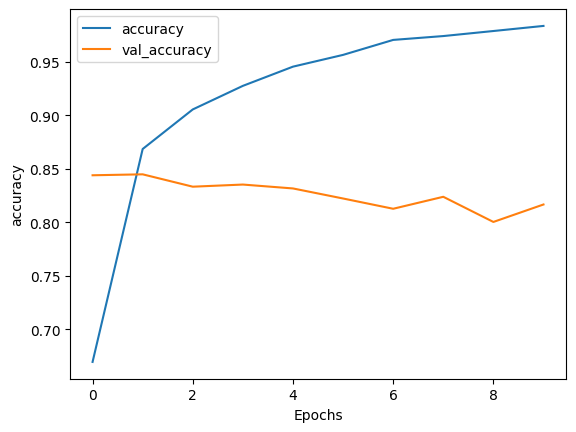

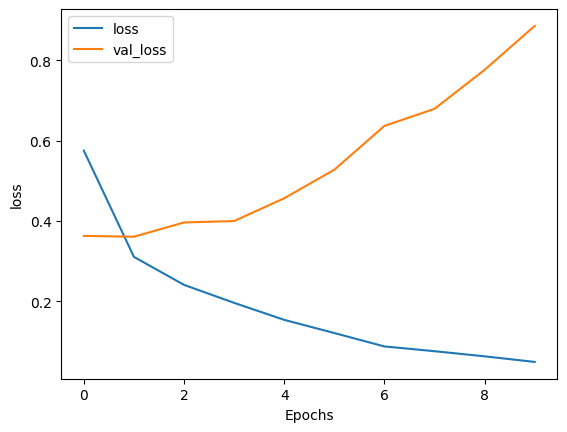

In [14]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

## Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [15]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171149 (668.55 KB)
Trainable params: 171149 (668.55 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [16]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 10s 46ms/step - loss: 0.5234 - accuracy: 0.7460 - val_loss: 0.3554 - val_accuracy: 0.8478
Epoch 2/10
196/196 [==============================] - 11s 56ms/step - loss: 0.2992 - accuracy: 0.8781 - val_loss: 0.3489 - val_accuracy: 0.8506
Epoch 3/10
196/196 [==============================] - 11s 57ms/step - loss: 0.2426 - accuracy: 0.9036 - val_loss: 0.3735 - val_accuracy: 0.8421
Epoch 4/10
196/196 [==============================] - 10s 53ms/step - loss: 0.2044 - accuracy: 0.9232 - val_loss: 0.4192 - val_accuracy: 0.8326
Epoch 5/10
196/196 [==============================] - 12s 63ms/step - loss: 0.1820 - accuracy: 0.9327 - val_loss: 0.4551 - val_accuracy: 0.8303
Epoch 6/10
196/196 [==============================] - 9s 46ms/step - loss: 0.1614 - accuracy: 0.9406 - val_loss: 0.4994 - val_accuracy: 0.8244
Epoch 7/10
196/196 [==============================] - 10s 52ms/step - loss: 0.1431 - accuracy: 0.9504 - val_loss: 0.5435 - val_accuracy: 

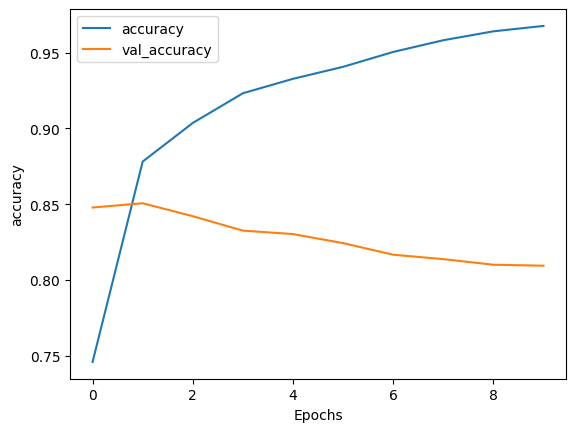

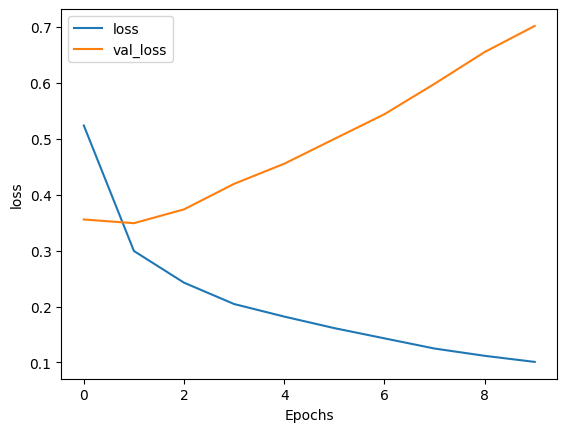

In [17]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')

## Wrap Up

Now that you've seen the results for each model, can you make a recommendation on what works best for this dataset? Do you still get the same results if you tweak some hyperparameters like the vocabulary size? Try tweaking some of the values some more so you can get more insight on what model performs best.